# Continuous Control

In this notebook, I'll train an agent to solve the Reacher Environment using Unity ML-Agents.

---

# Index

- []()
- []()
- []()
- []()
- []()

## 1. Setup the Environment

<img align="left" width="150" src="https://www.nclouds.com/img/services/toolkit/sagemaker.png"/>

This notebook was developed on AWS SageMaker.

The kernel used is **conda_python3**

To setup this environment on SageMaker you need to run the next 3 cells.

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install -r requirements.txt

In [ ]:
#!pip install torch===1.5.1 torchvision===0.6.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip -q install .././python

## 2. Start the Environment

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
from collections import deque
from agent import Agent

#env_path = "Reacher_Windows_x86_64/Reacher.exe"
env_path = "Reacher_Linux/Reacher.x86_64"

env = UnityEnvironment(file_name=env_path, no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 3. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 4. Define helper functions to training session

Here we'll create a function that can be very helpful to teach the agent.

In [4]:
def rl_trainer(agent, n_episodes=100, max_time_step=None, print_range=10, early_stop=13, agent_reset=False, verbose=False):
    """Deep Q-Learning trainer.
    
    Params
    ======
        agent (object): The agent object.
        n_episodes (int): maximum number of training episodes.
        max_time_step (int or None): The max time step per episode, if None, the agent will training until environment is done.
        print_range (int): range to print partials results.
        early_stop (int): Stop training when achieve a defined score respecting 10 min n_episodes.
        agent_reset (bool): If we need to reset agent at every episode.
        verbose (bool): If verbose true, we'll print some infos on console.
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=print_range)  # last scores
    scores_mean = []
    
    for i in range(1, n_episodes+1):
        #env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        if agent_reset:
            agent.reset()
            
        if isinstance(max_time_step, (int, float)):
            for time in range(max_time_step):
                action = agent.act(state)
                env_info = env.step(action)[brain_name]
                next_state = env_info.vector_observations[0]
                reward = env_info.rewards[0]
                done = env_info.local_done[0] 
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if time % 20:
                    print('\rTimestep {}\tScore: {:.2f}\tmin: {:.2f}\tmax: {:.2f}'
                          .format(time, np.mean(scores), np.min(scores), np.max(scores)), end="") 
                if done:
                    break
        else:
            while True:
                action = agent.act(state)
                env_info = env.step(action)[brain_name]
                next_state = env_info.vector_observations[0]
                reward = env_info.rewards[0]
                done = env_info.local_done[0] 
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        if verbose:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
            if i % print_range == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
            
        if np.mean(scores_window) >= early_stop and i > 10:
            if verbose:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
            break
            
    return scores, i, np.mean(scores_window)

## 5. Training the Agent

In the next code cells, we will train the Agent to work on environment.

Episode 10	Average Score: 0.31
Episode 20	Average Score: 0.31
Episode 30	Average Score: 0.07
Episode 40	Average Score: 0.20
Episode 50	Average Score: 0.77
Episode 60	Average Score: 0.67
Episode 70	Average Score: 0.60
Episode 80	Average Score: 0.67
Episode 90	Average Score: 0.74
Episode 100	Average Score: 0.94
Episode 110	Average Score: 1.11
Episode 120	Average Score: 1.31
Episode 130	Average Score: 1.51
Episode 140	Average Score: 1.45
Episode 150	Average Score: 1.08
Episode 160	Average Score: 1.49
Episode 170	Average Score: 1.11
Episode 180	Average Score: 1.61
Episode 190	Average Score: 1.13
Episode 200	Average Score: 0.86
Episode 210	Average Score: 1.03
Episode 220	Average Score: 0.71
Episode 230	Average Score: 0.68
Episode 240	Average Score: 0.31
Episode 250	Average Score: 0.39
Episode 260	Average Score: 0.21
Episode 270	Average Score: 0.05
Episode 280	Average Score: 0.00
Episode 290	Average Score: 0.06
Episode 300	Average Score: 0.05
Episode 310	Average Score: 0.00
Episode 320	Avera

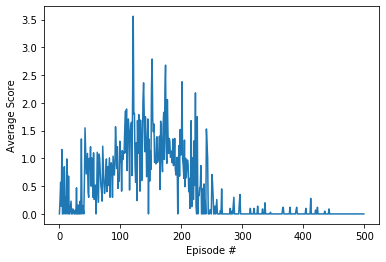

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment

agent = Agent(state_size=state_size, action_size=action_size)

scores, episodes, last_avg_score = rl_trainer(agent, n_episodes=500, max_time_step=None,
                                              early_stop=30, agent_reset=True, verbose=True)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

### 5.1 Agent losses visualization

In [ ]:
plt.plot(agent.losses)
plt.title("Losses")
plt.show()

### Save weights

In [ ]:
agent.save_model()

### Load weights

In [ ]:
agent.load_model()

## 6. Test Agent on Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance.

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
eps = 0.05
while True:
    action = agent.act(state, eps)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()